# Infection Rate Calibration: Analyze experiment output

Based on a fixed network model, we sweep over the infection rate parameter  𝛽  to find the one that minimizes a point process distance between realizations of simulated processes and the real time series.

In this notebook, we analyze the result of an experiment

Load libs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams.update({
    "figure.autolayout": False,
    "figure.figsize": (12, 5),
    "figure.dpi": 72,
    "axes.linewidth": 0.8,
    "xtick.major.width": 0.8,
    "xtick.minor.width": 0.8,
    "ytick.major.width": 0.8,
    "ytick.minor.width": 0.8,
    "text.usetex": True,
    "font.serif": "Linux Libertine O",
    "font.size": 16,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "legend.fontsize": 14,
    "legend.frameon": True,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "lines.linewidth": 2.0,
    "lines.markersize": 4,
    "grid.linewidth": 0.4,
    "pgf.texsystem": "xelatex",
    "pgf.preamble": [
        r'\usepackage{fontspec}',
        r'\usepackage{unicode-math}',
        r'\setmainfont{Linux Libertine O}',
        r'\setmathfont{Linux Libertine O}',
    ]
})

import os
import json
import random
import networkx as nx
from pprint import pprint

from lib.graph_generation import make_ebola_network
from lib.dynamics import SimulationSIR, PriorityQueue
from lib.dynamics import sample_seeds
from lib import utils
from lib import metrics
from lib.settings import DATA_DIR, PROJECT_DIR

---

First set the experiment directory

In [50]:
EXP_DIR = os.path.join(PROJECT_DIR, 'output', 'calibration-beta-05to09-1')

Extract the time period of the experiment (assumed constant over all jobs in the experiment folder)

In [59]:
param_filename = sorted([f for f in os.listdir(EXP_DIR) if f.startswith('param')])[0]
with open(os.path.join(EXP_DIR, param_filename), 'r') as f:
    param_dict = json.load(f)
start_day_str = param_dict['simulation']['start_day_str']
end_day_str = param_dict['simulation']['end_day_str']
del param_filename, param_dict

print(f"start day: {start_day_str}")
print(f"end day: {end_day_str}")

start day: 2014-05-01
end day: 2014-09-01


Load the Ebola dataset

In [52]:
# Load the dataframe of per-individual infection time
df_clean = pd.read_csv(os.path.join(DATA_DIR, 'ebola', 'rstb20160308_si_001_cleaned.csv'),
                       parse_dates=['infection_date'], 
                       infer_datetime_format=True)

district_list = list(set(df_clean['district']))

# Compute the delay between the beginning of the dataset, and the beginning of the experiment to rescale the timestamps
timedelta_since_start = pd.to_datetime(start_day_str) - df_clean.infection_date.min()
timestamp_delay = timedelta_since_start.days
df_clean['infection_timestamp'] -= timestamp_delay

# Filter-out infections outside of the experiment perdio
df_clean = df_clean[(df_clean.infection_date >= start_day_str) & (df_clean.infection_date < end_day_str)]

# Aggregate into time series of per-district infection times
data_inf_times = df_clean[df_clean.infection_date < end_day_str].groupby('district').agg({'infection_timestamp': list})['infection_timestamp'].apply(np.array).to_dict()

---

## Wassertein distance for point processes

In [56]:
output_file_list = [f for f in os.listdir(EXP_DIR) if f.startswith('output')]

result_list = []

for i, output_file in enumerate(output_file_list):
    print(f"\rProcess output file {i+1}/{len(output_file_list)}", end="")
    
    # Load output file
    with open(os.path.join(EXP_DIR, output_file), 'r') as f:
        output_data = json.load(f)
    
    param_filename = f"param-{'-'.join(output_file.split('-')[1:-1])}.json"
    with open(os.path.join(EXP_DIR, param_filename), 'r') as f:
        param_dict = json.load(f)
    beta = param_dict['simulation']['sir_params']['beta']
        
    # Format infection times series per district
    exp_inf_time = utils.compute_infection_time_per_district(output_data['inf_occured_at'], output_data['district'])
    
    # Compute distance
    dist = 0.0
    for district in district_list:
        if (district not in exp_inf_time) and (district not in data_inf_times):
            continue
        dist += metrics.wasserstein_distance(
            exp_inf_time.get(district, np.zeros(0)),
            data_inf_times.get(district, np.zeros(0))
        )
    
    result_list.append({
        'beta': beta,
        'wasserstein_distance': dist
    })

Process output file 650/650

In [57]:
df = pd.DataFrame(result_list)
df = df.groupby('beta').agg({'wasserstein_distance': ['min', 'max', 'mean', 'std', 'count']})
df = df.sort_index()

display(df)

wasserstein_distance                                                  
                          min            max           mean           std count
beta                                                                           
0.005000        122459.195971  147306.202268  132729.001022   6341.272437    50
0.005430        119734.823947  154315.412622  134922.061127   9291.132777    50
0.005941        119538.433741  156845.634047  138409.612640  11949.724792    50
0.006557        121359.168834  165325.120365  148277.251603  11329.832949    50
0.007317        115086.408405  172851.809045  151672.982227  14474.337823    50
0.008276        112393.896934  187126.315128  160886.765377  14840.227426    50
0.009524        115462.150465  198452.429704  168425.488884  18381.467041    50
0.011215        129587.382190  219720.642753  193677.009004  17734.627692    50
0.013636        162575.720280  285029.568315  238162.209316  22679.616718    50
0.017391        193867.902929  374606.187989  324578.758161  35566.983179    50
0.024000        438630.098322  501306.323603  473998.442644  12759.923063    50
0.038710        563699.638249  615070.610471  591465.222813   9830.647890    50
0.100000        670047.815630  688350.230068  678321.035009   3858.145719    50

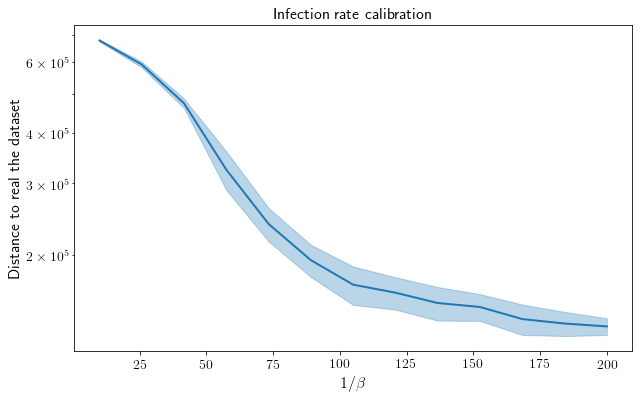

In [58]:
plt.figure(figsize=(10, 6))

plt.yscale('log')

x = 1/df.index
y_mean = df['wasserstein_distance']['mean']
y_std = df['wasserstein_distance']['std']

plt.plot(x, y_mean, c='C0')
plt.fill_between(x, y_mean - y_std, y_mean + y_std, color='C0', alpha=0.3)

plt.xlabel('$1/\\beta$')
plt.ylabel('Distance to real the dataset')

plt.title('Infection rate calibration');

# plt.ylim(8000, 10000)

---

## Estimation of basic reproduction number $R_0$ 

In [38]:
output_file_list = [f for f in os.listdir(EXP_DIR) if f.startswith('output')]

result_list = []

for i, output_file in enumerate(output_file_list):
    print(f"\rProcess output file {i+1}/{len(output_file_list)}", end="")
    
    # Load output file
    with open(os.path.join(EXP_DIR, output_file), 'r') as f:
        output_data = json.load(f)
    
    # Load param file
    param_filename = f"param-{'-'.join(output_file.split('-')[1:-1])}.json"
    with open(os.path.join(EXP_DIR, param_filename), 'r') as f:
        param_dict = json.load(f)
    beta = param_dict['simulation']['sir_params']['beta']
        
    # Compute R0 per country
    res_dict = utils.compute_r0_per_country(
        inf_time_arr=output_data['inf_occured_at'], 
        infector_arr=output_data['infector'], 
        country_arr=output_data['country']
    )
    
    res_dict['beta'] = beta
    
    result_list.append(res_dict)

Process output file 2112/2112

In [39]:
df = pd.DataFrame(result_list).groupby('beta').agg(['mean', 'std', 'count'])
df = df.sort_index()

df

Guinea                   Liberia                 Sierra Leone                
              mean       std count      mean       std count         mean       std count
beta                                                                                     
0.020000  1.012227  0.010044   100  0.969689  0.049308   100     0.995163  0.010550   100
0.020747  1.012670  0.009724   100  0.978621  0.015191   100     0.993622  0.010164   100
0.021552  1.011218  0.010135   100  0.976898  0.015206   100     0.996061  0.010532   100
0.022422  1.011464  0.009443   100  0.976895  0.013886   100     0.995433  0.010865   100
0.023364  1.011798  0.010211   100  0.978470  0.015045   100     0.994122  0.011430   100
0.024390  1.010214  0.009863   100  0.979025  0.015482   100     0.995827  0.009809   100
0.025510  1.009780  0.008322   100  0.978970  0.012291   100     0.996205  0.010045   100
0.026738  1.008839  0.009131   100  0.980284  0.013987   100     0.996408  0.010109   100
0.028090  1.011027  0.008260   100  0.975219  0.011777   100     0.996343  0.010490   100
0.029586  1.004456  0.051700   100  0.975713  0.014320    99     0.991264  0.067221   100
0.031250  1.010099  0.008222   100  0.976869  0.013420   100     0.996372  0.010682   100
0.033113  1.009272  0.008443   100  0.977006  0.014727   100     0.997244  0.009960   100
0.035211  1.010090  0.010046   100  0.973933  0.015443   100     0.997974  0.012434   100
0.037594  1.009173  0.008823   100  0.975993  0.016294   100     0.998006  0.010230   100
0.040323  1.010313  0.007325   100  0.972661  0.012066   100     0.998267  0.010212   100
0.043478  1.009554  0.007506   100  0.973430  0.013688   100     0.998882  0.008638   100
0.047170  1.010836  0.007159   100  0.971822  0.014775   100     0.997836  0.009413   100
0.051546  1.011403  0.008169   100  0.967737  0.014751   100     0.999441  0.010179   100
0.056818  1.011311  0.007956   100  0.968973  0.014809   100     0.998822  0.009567   100
0.063291  1.009981  0.008159   100  0.970099  0.014518   100     1.000355  0.010902   100
0.071429  1.010120  0.007205   100  0.968891  0.012236   100     1.000942  0.010155   100
0.081967  1.006481  0.005003    12  0.966603  0.016690    12     1.008628  0.005754    12

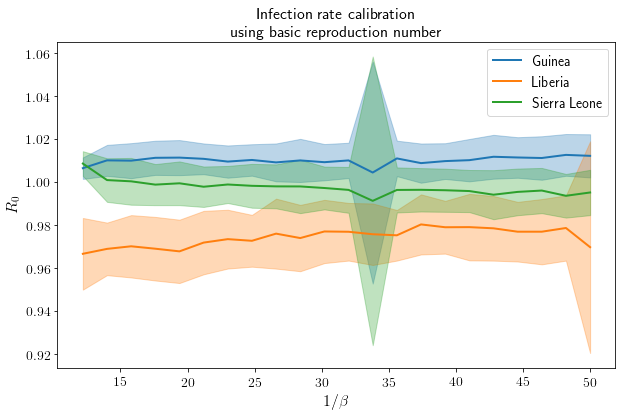

In [40]:
plt.figure(figsize=(10, 6))

x = 1 / df.index

for i, country in enumerate(['Guinea', 'Liberia', 'Sierra Leone']):
    y_mean = df[country]['mean']
    y_std = df[country]['std']
    
    plt.plot(x, y_mean, c=f'C{i}', label=country)
    plt.fill_between(x, y_mean - y_std, y_mean + y_std, color=f'C{i}', alpha=0.3)

plt.xlabel('$1/\\beta$')
plt.ylabel('$R_0$')
plt.legend()

plt.title('Infection rate calibration\nusing basic reproduction number');

In [37]:
from collections import defaultdict, Counter

def compute_r0_per_country(inf_time_arr, infector_arr, country_arr):
    """
    Compute the basic reproduction number R0 per country for the given data.

    inf_time_arr : array-like (shape: (N,))
        Infection time of each of the N nodes
    infector_arr : array-like (shape: (N,))
        Index of the
    """
    # Count of secondary infections: {node_idx: num of infected neighbors}
    infector_count = Counter(infector_arr)
    # Indices of infected nodes
    infected_node_indices = np.where(np.array(inf_time_arr) < np.inf)[0]
    # Initialize the list of number of secondary infections per country
    country_count = defaultdict(list)
    # For each infected node, add its number of secondary case to its country
    for u_idx in infected_node_indices:
        u_country = country_arr[u_idx]
        inf_count = infector_count[u_idx]
        country_count[u_country].append(inf_count)
    country_count = dict(country_count)
    # Compute R0 as the mean number of secondary case for each country
    countru_r0_dict = {country: np.mean(count) for country, count in country_count.items()}
    return countru_r0_dict